### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

<IPython.core.display.Javascript object>


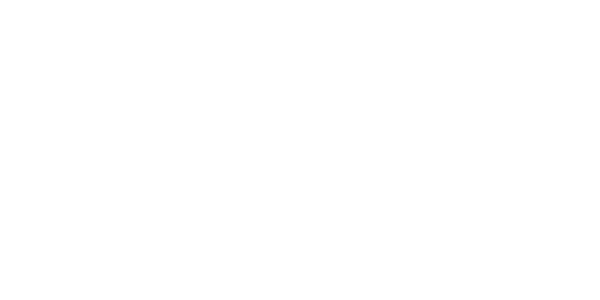

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS

1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el **algoritmo LMS normalizado**
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (45%) Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta


# Solucion

In [7]:
%matplotlib notebook
import numpy as np
import scipy.signal
import scipy.fft as sfft
import matplotlib.pylab as plt
from matplotlib import animation

from IPython.display import YouTubeVideo, HTML, Audio
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, show, output_notebook
output_notebook()

Loading BokehJS ...

## Predicción con algoritmo LMS

### Descripcion de algoritmo 

El algoritmo LMS pertenece a la familia de los algoritmos de gradiente estocástico. Una característica importante de este algoritmo es su simplicidad, no requiere medidas de las funciones de correlación, ni inversión de la matriz de autocorrelación.

LMS se compone de dos procesos:

- Un proceso de filtrado, este implica el cálculo de la salida generada por un filtro transversal y la generación de una estimación del error comparando la salida con la respuesta deseada.
- Un proceso adaptativo, realiza el ajuste automático de los coeficientes del filtro de acuerdo a la estimación del error.

Considerando la función de costo estocástica para la arquitectura FIR, algunas cosas que podemos decir son:

La complejidad de este algoritmo es $L+1$, es decir, la complejidad del filtro.

Este algoritmo tiende en la media al valor óptimo
$$\mathbb{E}[w_n] \rightarrow w^*$$

para $n\rightarrow \infty$

Este algoritmo, además converge en la media cuadrada: La varianza de $w_n - w^*$ tiende al valor mínimo de $J$ para $n\rightarrow \infty$ si cumple que

$$0 < \mu < \frac{2}{Tr[R_{uu}]}$$

donde $R_{uu}=\mathbb{E}[u_nu_n^T]$ es la matriz de autocorrelación y $Tr[]$ el operador que calcula la traza de una matriz.

### Implementacion del predictor


In [8]:
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        # Asumiendo que un = [u[n], u[n-1], ..., u[n-L]]
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn

### Respuesta 1.1.2 (TAU = 17)

In [9]:
L = [5,10,15,20,25,30]
mus =  np.logspace(-2, 0, num=100)
y_pred = np.zeros(shape=(len(y_valid)))
best_mu_t17 = 0
best_L_t17 = 0
best_NMSE_t17 = 0
for i in range(len(L)):
    for j in range(len(mus)):   
        myfilter = Filtro_NLMS(L=L[i], mu=mus[j])
        #Entrenamiento 
        for k in range(L[i]+1, len(y_train)):
            myfilter.update(y_train[k-L[i]-1:k][::-1], y_train[k])
        #validacion
        for k in range(L[i]+1, len(y_valid)):
            y_pred[k] = myfilter.update(y_valid[k-L[i]-1:k][::-1], y_valid[k])
        if (i == 0 and j ==0):
            best_NMSE_t17 = NMSE(y_valid,y_pred)
            best_mu_t17= mus[j]
            best_L_t17 = L[i]
        else:
            error = NMSE(y_valid,y_pred)
            if(error < best_NMSE_t17):
                best_NMSE_t17 = error
                best_mu_t17= mus[j]
                best_L_t17 = L[i]
            print(str(error)+' no es menor que '+str(best_NMSE_t17)+' mu = '+str(mus[j])+' L = '+str(L[i]))
    print('----------------------------------------------------------------------')
print('mejor mu = '+str(best_mu_t17))

386.8779558615624 no es menor que 386.8779558615624 mu = 0.010476157527896646 L = 5
383.62979045092334 no es menor que 383.62979045092334 mu = 0.010974987654930561 L = 5
380.31957895833955 no es menor que 380.31957895833955 mu = 0.011497569953977356 L = 5
376.9501328422297 no es menor que 376.9501328422297 mu = 0.012045035402587823 L = 5
373.5244623358487 no es menor que 373.5244623358487 mu = 0.012618568830660204 L = 5
370.04580270502174 no es menor que 370.04580270502174 mu = 0.013219411484660288 L = 5
366.51763309201533 no es menor que 366.51763309201533 mu = 0.013848863713938732 L = 5
362.94368916112666 no es menor que 362.94368916112666 mu = 0.014508287784959394 L = 5
359.3279706773379 no es menor que 359.3279706773379 mu = 0.01519911082952934 L = 5
355.6747450177454 no es menor que 355.6747450177454 mu = 0.015922827933410922 L = 5
351.9885474665183 no es menor que 351.9885474665183 mu = 0.016681005372000592 L = 5
348.2741789994583 no es menor que 348.2741789994583 mu = 0.01747528

1172.813470050767 no es menor que 251.66856802001263 mu = 0.01 L = 10
1170.9823917089286 no es menor que 251.66856802001263 mu = 0.010476157527896646 L = 10
1169.1233419269433 no es menor que 251.66856802001263 mu = 0.010974987654930561 L = 10
1167.238759479764 no es menor que 251.66856802001263 mu = 0.011497569953977356 L = 10
1165.3313256670583 no es menor que 251.66856802001263 mu = 0.012045035402587823 L = 10
1163.4039685401135 no es menor que 251.66856802001263 mu = 0.012618568830660204 L = 10
1161.459864871698 no es menor que 251.66856802001263 mu = 0.013219411484660288 L = 10
1159.5024394865059 no es menor que 251.66856802001263 mu = 0.013848863713938732 L = 10
1157.5353616342675 no es menor que 251.66856802001263 mu = 0.014508287784959394 L = 10
1155.5625381342522 no es menor que 251.66856802001263 mu = 0.01519911082952934 L = 10
1153.5881030571518 no es menor que 251.66856802001263 mu = 0.015922827933410922 L = 10
1151.6164037445437 no es menor que 251.66856802001263 mu = 0.01

1320.9739794681698 no es menor que 251.66856802001263 mu = 0.8697490026177834 L = 10
1391.1428670677196 no es menor que 251.66856802001263 mu = 0.9111627561154896 L = 10
1550.7612544841882 no es menor que 251.66856802001263 mu = 0.9545484566618342 L = 10
4288.414832432639 no es menor que 251.66856802001263 mu = 1.0 L = 10
----------------------------------------------------------------------
1211.3920992551584 no es menor que 251.66856802001263 mu = 0.01 L = 15
1208.8617603769565 no es menor que 251.66856802001263 mu = 0.010476157527896646 L = 15
1206.2833805951 no es menor que 251.66856802001263 mu = 0.010974987654930561 L = 15
1203.6596496185357 no es menor que 251.66856802001263 mu = 0.011497569953977356 L = 15
1200.9935635574036 no es menor que 251.66856802001263 mu = 0.012045035402587823 L = 15
1198.2884415357637 no es menor que 251.66856802001263 mu = 0.012618568830660204 L = 15
1195.5479386697136 no es menor que 251.66856802001263 mu = 0.013219411484660288 L = 15
1192.7760552220

1136.8809040038016 no es menor que 251.66856802001263 mu = 0.7924828983539177 L = 15
1142.1927228256159 no es menor que 251.66856802001263 mu = 0.8302175681319748 L = 15
1150.4854608072196 no es menor que 251.66856802001263 mu = 0.8697490026177834 L = 15
1165.5018842504817 no es menor que 251.66856802001263 mu = 0.9111627561154896 L = 15
1199.9158334865697 no es menor que 251.66856802001263 mu = 0.9545484566618342 L = 15
2078.253342987902 no es menor que 251.66856802001263 mu = 1.0 L = 15
----------------------------------------------------------------------
1170.2632626641657 no es menor que 251.66856802001263 mu = 0.01 L = 20
1168.34314178651 no es menor que 251.66856802001263 mu = 0.010476157527896646 L = 20
1166.3869393508287 no es menor que 251.66856802001263 mu = 0.010974987654930561 L = 20
1164.3967067205258 no es menor que 251.66856802001263 mu = 0.011497569953977356 L = 20
1162.3747499544445 no es menor que 251.66856802001263 mu = 0.012045035402587823 L = 20
1160.3236387180862

1137.2163536067621 no es menor que 251.66856802001263 mu = 0.7924828983539177 L = 20
1142.7120682100865 no es menor que 251.66856802001263 mu = 0.8302175681319748 L = 20
1150.4701662469856 no es menor que 251.66856802001263 mu = 0.8697490026177834 L = 20
1163.0027804618928 no es menor que 251.66856802001263 mu = 0.9111627561154896 L = 20
1192.2546321317336 no es menor que 251.66856802001263 mu = 0.9545484566618342 L = 20
1453.439818287213 no es menor que 251.66856802001263 mu = 1.0 L = 20
----------------------------------------------------------------------
1189.302843943326 no es menor que 251.66856802001263 mu = 0.01 L = 25
1187.0175279944729 no es menor que 251.66856802001263 mu = 0.010476157527896646 L = 25
1184.6853983535018 no es menor que 251.66856802001263 mu = 0.010974987654930561 L = 25
1182.3086147227111 no es menor que 251.66856802001263 mu = 0.011497569953977356 L = 25
1179.889621689291 no es menor que 251.66856802001263 mu = 0.012045035402587823 L = 25
1177.431165125246 

1135.3668188350823 no es menor que 251.66856802001263 mu = 0.7924828983539177 L = 25
1140.732895822759 no es menor que 251.66856802001263 mu = 0.8302175681319748 L = 25
1149.0183521252168 no es menor que 251.66856802001263 mu = 0.8697490026177834 L = 25
1163.3717029124077 no es menor que 251.66856802001263 mu = 0.9111627561154896 L = 25
1193.7123957077424 no es menor que 251.66856802001263 mu = 0.9545484566618342 L = 25
1635.5905723009466 no es menor que 251.66856802001263 mu = 1.0 L = 25
----------------------------------------------------------------------
1183.3413148568966 no es menor que 251.66856802001263 mu = 0.01 L = 30
1181.5906311722379 no es menor que 251.66856802001263 mu = 0.010476157527896646 L = 30
1179.8037446214448 no es menor que 251.66856802001263 mu = 0.010974987654930561 L = 30
1177.9822631519698 no es menor que 251.66856802001263 mu = 0.011497569953977356 L = 30
1176.1280212619884 no es menor que 251.66856802001263 mu = 0.012045035402587823 L = 30
1174.24309072973

1136.2547964714015 no es menor que 251.66856802001263 mu = 0.6579332246575682 L = 30
1139.238697671416 no es menor que 251.66856802001263 mu = 0.6892612104349699 L = 30
1142.836644262231 no es menor que 251.66856802001263 mu = 0.7220809018385468 L = 30
1147.3497910112876 no es menor que 251.66856802001263 mu = 0.7564633275546291 L = 30
1153.33746094122 no es menor que 251.66856802001263 mu = 0.7924828983539177 L = 30
1161.971479026113 no es menor que 251.66856802001263 mu = 0.8302175681319748 L = 30
1176.135784207377 no es menor que 251.66856802001263 mu = 0.8697490026177834 L = 30
1204.7137068557292 no es menor que 251.66856802001263 mu = 0.9111627561154896 L = 30
1289.2279062188068 no es menor que 251.66856802001263 mu = 0.9545484566618342 L = 30
2990.311347955045 no es menor que 251.66856802001263 mu = 1.0 L = 30
----------------------------------------------------------------------
mejor mu = 0.09770099572992257


<IPython.core.display.Javascript object>


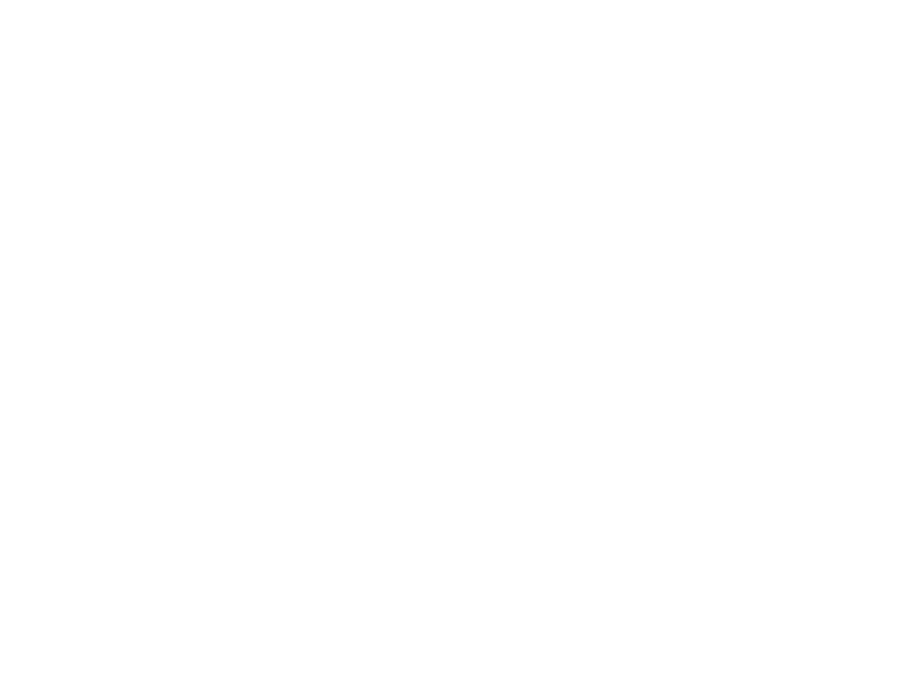

Text(0.5, 1.0, 'Residuos de la prediccion')

In [10]:
L = best_L_t17
mu = best_mu_t17
y_pred17_lms = np.zeros(shape=(len(y_test)))
myfilter = Filtro_NLMS(L=L, mu=mu)
#Entrenamiento 
for k in range(L+1, len(y_train)):
    myfilter.update(y_train[k-L-1:k][::-1], y_train[k])
#validacion

for k in range(L+1, len(y_valid)):
    y_pred17_lms[k] = myfilter.update(y_valid[k-L-1:k][::-1], y_valid[k])
    
fig, ax = plt.subplots(2, 1, figsize=(9, 7), tight_layout=True)
ax[0].plot(t_valid, y_valid, linewidth=2, alpha=0.75, label='real')
ax[0].set_title('Serie de tiempo real vs predecido (TAU = 17, mu = '+str(mu)+', L = '+str(L)+')')
ax[0].plot(t_valid, y_pred17_lms, linewidth=2, alpha=0.75, label='predecido')
ax[0].legend()
ax[1].plot(t_valid,(y_valid-y_pred17_lms)**2, color = 'red', label= 'tau = 17')
ax[1].set_title('Residuos de la prediccion')

#### Observaciones

Podemos ver que que la fase de validacion nos sirve para ajustar los parametros, en este caso para poder escoger un buen mu y L fuimos probando las combinaciones hasta llegar a un NMSE menor. Obteniendo los valores de mu = 0.0977 y L = 5. al ocupar estos parametros en el sistema debilmente caotico podemos observar que los valores predecidos en el conjunto de validacion son muy cercanos a los valores reales, cuyos residuos son minimos.

### Respuesta 1.1.3 (TAU = 30)

<IPython.core.display.Javascript object>


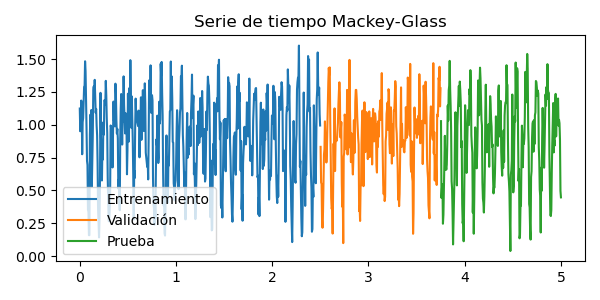

In [11]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();

In [12]:
L = [5,10,15,20,25,30]
mus =  np.logspace(-2, 0, num=100)
y_pred = np.zeros(shape=(len(y_valid)))
best_mu_t30 = 0
best_L_t30 = 0
best_NMSE_t30 = 0
for i in range(len(L)):
    for j in range(len(mus)):   
        myfilter = Filtro_NLMS(L=L[i], mu=mus[j])
        #Entrenamiento 
        for k in range(L[i]+1, len(y_train)):
            myfilter.update(y_train[k-L[i]-1:k][::-1], y_train[k])
        #validacion
        for k in range(L[i]+1, len(y_valid)):
            y_pred[k] = myfilter.update(y_valid[k-L[i]-1:k][::-1], y_valid[k])
        if (i == 0 and j ==0):
            best_NMSE_t30 = NMSE(y_valid,y_pred)
            best_mu_t30 = mus[j]
            best_L_t30 = L[i]
        else:
            error = NMSE(y_valid,y_pred)
            if(error < best_NMSE_t30):
                best_NMSE_t30 = error
                best_mu_t30= mus[j]
                best_L_t30 = L[i]
            

<IPython.core.display.Javascript object>


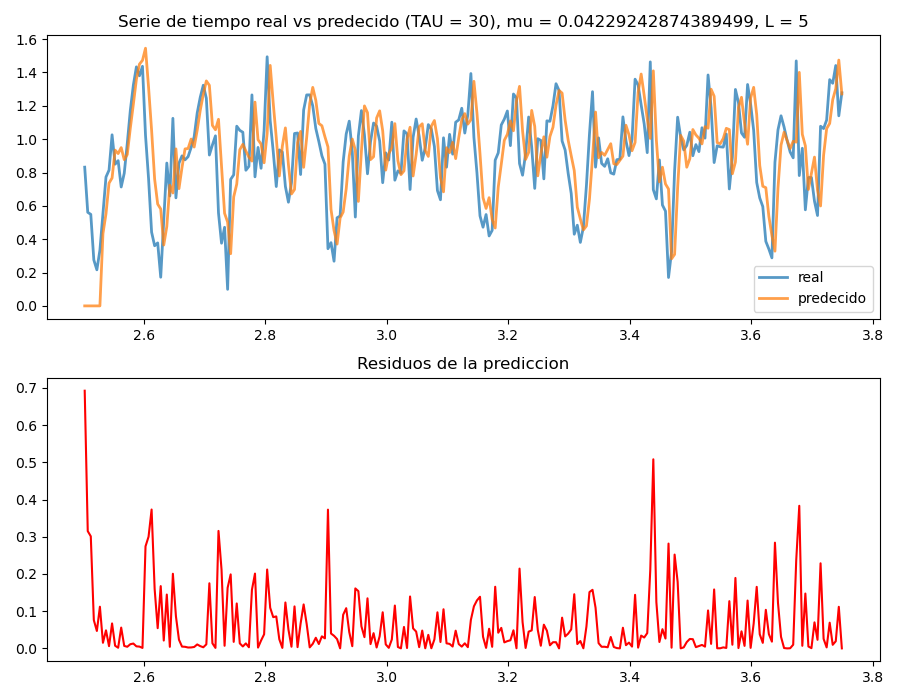

Text(0.5, 1.0, 'Residuos de la prediccion')

In [13]:
L = best_L_t30
mu = best_mu_t30
y_pred30_lms = np.zeros(shape=(len(y_test)))
myfilter = Filtro_NLMS(L=L, mu=mu)
#Entrenamiento 
for k in range(L+1, len(y_train)):
    myfilter.update(y_train[k-L-1:k][::-1], y_train[k])
#valid
for k in range(L+1, len(y_valid)):
    y_pred30_lms[k] = myfilter.update(y_valid[k-L-1:k][::-1], y_valid[k])
    
fig, ax = plt.subplots(2, 1, figsize=(9, 7), tight_layout=True)
ax[0].plot(t_valid, y_valid, linewidth=2, alpha=0.75, label='real')
ax[0].set_title('Serie de tiempo real vs predecido (TAU = 30), mu = '+str(mu)+', L = '+str(L))
ax[0].plot(t_valid, y_pred30_lms, linewidth=2, alpha=0.75, label='predecido')
ax[0].legend()
ax[1].plot(t_valid,(y_valid-y_pred30_lms)**2, color = 'red', label= 'tau = 30')
ax[1].set_title('Residuos de la prediccion')

#### Observaciones

En este caso para un sistema fuertemente caotico se nos hace mas dificil encontrar unos buenos parametros para disminuir el NMSE, ya que como se ve en los residuos estos son menos armonicos. podemos decir esto por que en cambio con el sistema debilmente caotico este no adquiere una estabilizacion en sus residuos.  

### Respuesta 1.1.4

#### Comparacion resultados anteriores

Como se menciono anteriormente, la diferencia entre los resultados obtenidos entre el sistema fuertemente caotico y el debilmente caotico es el ajuste que tendra los valores predecidos con los valores reales. esto lo vimos en sus graficos de residuo donde el sistema debilmente caotico llega a estabilizarse alcanzando como valores maximos 0.2, en cambio el sistema fuertemente caotico no logra esto, alcanzando valores de 0.5.  

#### Prediccion conjunto de pruebas

<IPython.core.display.Javascript object>


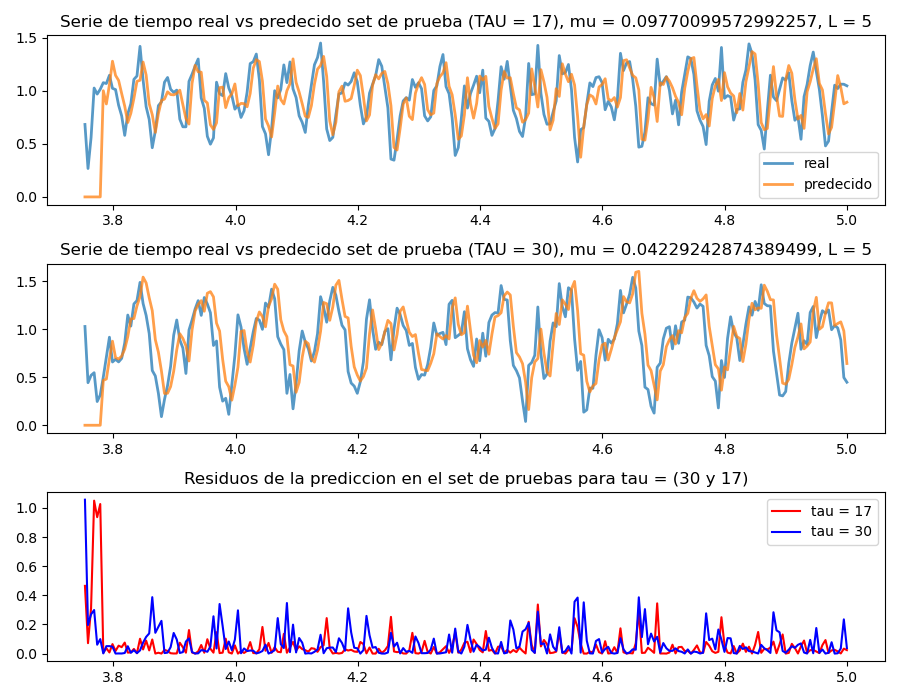

In [14]:
L30 = best_L_t30
mu30 = best_mu_t30
L17 = best_L_t17
mu17 = best_mu_t17

#tau = 17
(t_train17, y_train17), (t_valid17, y_valid17), (t_test17, y_test17) = MackeyGlass(tau=17.)
y_pred17_lms = np.zeros(shape=(len(y_test17)))
myfilter = Filtro_NLMS(L=L17, mu=mu17)
#Entrenamiento 
for k in range(L17+1, len(y_train17)):
    myfilter.update(y_train17[k-L17-1:k][::-1], y_train17[k])
#test
for k in range(L17+1, len(y_test17)):
    y_pred17_lms[k] = myfilter.update(y_test17[k-L17-1:k][::-1], y_test17[k])
    
fig, ax = plt.subplots(3, 1, figsize=(9, 7), tight_layout=True)
ax[0].plot(t_test17, y_test17, linewidth=2, alpha=0.75, label='real')
ax[0].set_title('Serie de tiempo real vs predecido set de prueba (TAU = 17), mu = '+str(mu17)+', L = '+str(L17))
ax[0].plot(t_test17, y_pred17_lms, linewidth=2, alpha=0.75, label='predecido')
ax[0].legend()

#tau = 30
(t_train30, y_train30), (t_valid30, y_valid30), (t_test30, y_test30) = MackeyGlass(tau=30.)
y_pred30_lms = np.zeros(shape=(len(y_test30)))
myfilter = Filtro_NLMS(L=L30, mu=mu30)
#Entrenamiento 
for k in range(L30+1, len(y_train30)):
    myfilter.update(y_train30[k-L30-1:k][::-1], y_train30[k])
#test
for k in range(L30+1, len(y_test30)):
    y_pred30_lms[k] = myfilter.update(y_test30[k-L30-1:k][::-1], y_test30[k])
ax[1].plot(t_test30, y_test30, linewidth=2, alpha=0.75, label='real')
ax[1].plot(t_test30, y_pred30_lms, linewidth=2, alpha=0.75, label='predecido')
ax[1].set_title('Serie de tiempo real vs predecido set de prueba (TAU = 30), mu = '+str(mu)+', L = '+str(L30))
ax[0].legend()


#Residuos
ax[2].plot(t_test17,(y_test17-y_pred17_lms)**2, color = 'red', label= 'tau = 17')
ax[2].plot(t_test30,(y_test30-y_pred30_lms)**2, color = 'blue', label= 'tau = 30')
ax[2].set_title('Residuos de la prediccion en el set de pruebas para tau = (30 y 17)')
ax[2].legend()

#### Discusion y analisis

Podemos decir que al comparar el sistema fuertemente caotico con el debilmente caotico en el conjunto de prueba, estos logran su objetivo ya que como se ve en los graficos, los valores predecidos de ambos se logran parecer a su conjunto real. Por otro lado podemos ver que para el intervalo 4.7 aprox a 5.0 el sistema debilmente caotico decae mas, asimilando una mejor comparacion entre el valor predecido con el real. 

## Prediccion con algoritmo RLS

### Descripcion del algoritmo

Existen casos en los que el algoritmo LMS tarda demasiado en converger. Para estos casos podemos obtener una convergencia más rápida si reemplazamos el error instantaneo por el error histórico, es decir, la suma de los errores desde la muestra inicial hasta la actual. El algoritmo RLS es un método que minimiza este error. 

Si consideramos un filtro FIR con L+1 pesos que se actualizan en cada época

$$y_n=\sum_{k=0}^{L}w_{n,k}u_{n-k}$$

$$
\begin{align}
J^H_n(\textbf{w}) &= \sum_{i=L}^n   \beta^{n-i} |e_i|^2 \nonumber \\
&= \sum_{i=L}^n \beta^{n-i} (d_i - \sum_{k=0}^{L} w_{i, k} u_{i-k} )^2, \nonumber
\end{align}
$$

donde $n$ es el índice del instante actual y $\beta \in [0,1]$ es el "factor de olvido", que usualmente es un valor cercano, pero menor a 1.

También se agrega un regularizador a los pesos para evitar divergencias en el entrenamiento

$$ J^w_n = \lambda  \| \textbf{w}_{n} \|^2 = \lambda \sum_{k=1} w_{n, k}^2 $$

RLS tiene dos tipos de soluciones, la primera es la cerrada que tiene parecido a la del filtro de Wiener, pero no es fácil actualizarla a medida que llegan nuevas observaciones, además de ser muy costosa debido al cálculo del inverso de la matriz de correlación.

La segunda es la solución recursiva que nos da un algoritmo de orden cuadrático en vez de orden cúbico, sigue siendo de orden mayor a LMS, pero converge más rápidamente.

### Implementacion del predictor

In [15]:
class Filtro_RLS:
    
    def __init__(self, L, beta=0.99, lamb=1e-2):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.beta = beta
        self.lamb = lamb
        self.Phi_inv = lamb*np.eye(L+1)
        
    def update(self, un, dn):
        # Cálculo de la ganancia
        pi = np.dot(un.T, self.Phi_inv)
        kn = pi.T/(self.beta + np.inner(pi, un))
        # Actualizar el vector de pesos
        error = dn - np.dot(self.w, un)
        self.w += kn*error
        # Actualizar el inverso de Phi
        self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
        return np.dot(self.w, un)

### Respuesta 1.2.2 (TAU = 17)

In [16]:
L = [5,10,15,20,25,30]
b = np.arange(0.9,1,0.001)
best_b_t17 = 0
best_L_t17 = 0
best_NMSE_t17 = 0
(t_train17, y_train17), (t_valid17, y_valid17), (t_test17, y_test17) = MackeyGlass(tau=17.)
y_pred17 = np.zeros(shape=(len(y_valid17)))

for i in range(len(L)):
    for j in range(len(b)):   
        myfilter = Filtro_RLS(L[i], b[j])
        #Entrenamiento 
        for k in range(L[i]+1, len(y_train17)):
            myfilter.update(y_train17[k-L[i]-1:k][::-1], y_train17[k])
        #validacion
        for k in range(L[i]+1, len(y_valid17)):
            y_pred17[k] = myfilter.update(y_valid17[k-L[i]-1:k][::-1], y_valid17[k])
        if (i == 0 and j ==0):
            best_NMSE_t17 = NMSE(y_valid17,y_pred17)
            best_b_t17= b[j]
            best_L_t17 = L[i]
        else:
            error = NMSE(y_valid17,y_pred17)
            if(error < best_NMSE_t17):
                best_NMSE_t17 = error
                best_b_t17= b[j]
                best_L_t17 = L[i]
            else:
                print(str(error)+' no es menor que : '+str(best_NMSE_t17)+', L = '+str(L[i])+' b = '+str(b[j]))
    print('-----------------------------------------------------------------------------------------------')
print('Mejor L: '+str(best_L_t17))
print('Mejor b: '+str(best_b_t17))

69.3957076485715 no es menor que : 69.35506910628771, L = 5 b = 0.902
69.39819671781882 no es menor que : 69.35506910628771, L = 5 b = 0.903
69.35689763139115 no es menor que : 69.35506910628771, L = 5 b = 0.904
239.14105783785888 no es menor que : 69.35506910628771, L = 5 b = 0.905
69.94120412648861 no es menor que : 69.35506910628771, L = 5 b = 0.906
69.36505450948333 no es menor que : 69.35506910628771, L = 5 b = 0.907
76.02554767448198 no es menor que : 69.35506910628771, L = 5 b = 0.908
70.18173847416033 no es menor que : 69.35506910628771, L = 5 b = 0.909
69.51445270676325 no es menor que : 69.35506910628771, L = 5 b = 0.91
69.50459292648937 no es menor que : 69.35506910628771, L = 5 b = 0.911
71.79708060293054 no es menor que : 69.35506910628771, L = 5 b = 0.912
71.04344356081742 no es menor que : 69.35506910628771, L = 5 b = 0.913
77.71503484840068 no es menor que : 69.35506910628771, L = 5 b = 0.914
2339.113099178655 no es menor que : 69.35506910628771, L = 5 b = 0.915
81.6363

76.82644436449057 no es menor que : 69.35506910628771, L = 10 b = 0.912
82.61149475216786 no es menor que : 69.35506910628771, L = 10 b = 0.913
78.72470748499744 no es menor que : 69.35506910628771, L = 10 b = 0.914
88.12405959222585 no es menor que : 69.35506910628771, L = 10 b = 0.915
119.3480246600868 no es menor que : 69.35506910628771, L = 10 b = 0.916
318.37933051381367 no es menor que : 69.35506910628771, L = 10 b = 0.917
118.06319797492502 no es menor que : 69.35506910628771, L = 10 b = 0.918
87.84884085728498 no es menor que : 69.35506910628771, L = 10 b = 0.919
112.70929778722108 no es menor que : 69.35506910628771, L = 10 b = 0.92
503.88977095799953 no es menor que : 69.35506910628771, L = 10 b = 0.921
4493.868769283828 no es menor que : 69.35506910628771, L = 10 b = 0.922
183.93362808040476 no es menor que : 69.35506910628771, L = 10 b = 0.923
342.5978559510118 no es menor que : 69.35506910628771, L = 10 b = 0.924
548.6017977508695 no es menor que : 69.35506910628771, L = 1

93.98785407654383 no es menor que : 69.35506910628771, L = 15 b = 0.915
110.79346829015782 no es menor que : 69.35506910628771, L = 15 b = 0.916
1729.542781671214 no es menor que : 69.35506910628771, L = 15 b = 0.917
234.08782103374088 no es menor que : 69.35506910628771, L = 15 b = 0.918
460.3259409979567 no es menor que : 69.35506910628771, L = 15 b = 0.919
277.9400940151761 no es menor que : 69.35506910628771, L = 15 b = 0.92
131.61360948069805 no es menor que : 69.35506910628771, L = 15 b = 0.921
312.879948481344 no es menor que : 69.35506910628771, L = 15 b = 0.922
166.81901151515575 no es menor que : 69.35506910628771, L = 15 b = 0.923
208.74424351127874 no es menor que : 69.35506910628771, L = 15 b = 0.924
424.54347356080063 no es menor que : 69.35506910628771, L = 15 b = 0.925
136.138594169701 no es menor que : 69.35506910628771, L = 15 b = 0.926
5766.926359522204 no es menor que : 69.35506910628771, L = 15 b = 0.927
366.32113181285246 no es menor que : 69.35506910628771, L = 1

119.43008865256768 no es menor que : 69.35506910628771, L = 20 b = 0.92
277.3058021200978 no es menor que : 69.35506910628771, L = 20 b = 0.921
457.5018848226992 no es menor que : 69.35506910628771, L = 20 b = 0.922
272.0445742508681 no es menor que : 69.35506910628771, L = 20 b = 0.923
97.73626690088227 no es menor que : 69.35506910628771, L = 20 b = 0.924
1472.832058654106 no es menor que : 69.35506910628771, L = 20 b = 0.925
86.83365876182839 no es menor que : 69.35506910628771, L = 20 b = 0.926
102.97071759895434 no es menor que : 69.35506910628771, L = 20 b = 0.927
835.7041357284098 no es menor que : 69.35506910628771, L = 20 b = 0.928
2013.6979891104365 no es menor que : 69.35506910628771, L = 20 b = 0.929
221.9080307593122 no es menor que : 69.35506910628771, L = 20 b = 0.93
116.35429020715075 no es menor que : 69.35506910628771, L = 20 b = 0.931
105.92990689876838 no es menor que : 69.35506910628771, L = 20 b = 0.932
210.87656135265323 no es menor que : 69.35506910628771, L = 2

167.31369515085828 no es menor que : 69.35506910628771, L = 25 b = 0.925
107.16239829107295 no es menor que : 69.35506910628771, L = 25 b = 0.926
97.24089253756182 no es menor que : 69.35506910628771, L = 25 b = 0.927
112.55682604431873 no es menor que : 69.35506910628771, L = 25 b = 0.928
100.30572961803158 no es menor que : 69.35506910628771, L = 25 b = 0.929
151.82073959067722 no es menor que : 69.35506910628771, L = 25 b = 0.93
184.48523143701556 no es menor que : 69.35506910628771, L = 25 b = 0.931
133.89057991595953 no es menor que : 69.35506910628771, L = 25 b = 0.932
98.54459990318495 no es menor que : 69.35506910628771, L = 25 b = 0.933
98.73845821581209 no es menor que : 69.35506910628771, L = 25 b = 0.934
108.95584821041196 no es menor que : 69.35506910628771, L = 25 b = 0.935
100.55431159404341 no es menor que : 69.35506910628771, L = 25 b = 0.936
222.48241859384171 no es menor que : 69.35506910628771, L = 25 b = 0.937
1027.1550349006545 no es menor que : 69.35506910628771,

93.29848075085897 no es menor que : 69.35506910628771, L = 30 b = 0.926
341.8674670523796 no es menor que : 69.35506910628771, L = 30 b = 0.927
14438.507241539271 no es menor que : 69.35506910628771, L = 30 b = 0.928
177.2216919630362 no es menor que : 69.35506910628771, L = 30 b = 0.929
100.27707702191007 no es menor que : 69.35506910628771, L = 30 b = 0.93
289.32359583509464 no es menor que : 69.35506910628771, L = 30 b = 0.931
96.32327611042015 no es menor que : 69.35506910628771, L = 30 b = 0.932
1004.818352889457 no es menor que : 69.35506910628771, L = 30 b = 0.933
117.01459456084868 no es menor que : 69.35506910628771, L = 30 b = 0.934
210.48685285514915 no es menor que : 69.35506910628771, L = 30 b = 0.935
152.77151453259725 no es menor que : 69.35506910628771, L = 30 b = 0.936
106.32325399435287 no es menor que : 69.35506910628771, L = 30 b = 0.937
134.45041163648457 no es menor que : 69.35506910628771, L = 30 b = 0.9380000000000001
120.77121295348367 no es menor que : 69.3550

<IPython.core.display.Javascript object>


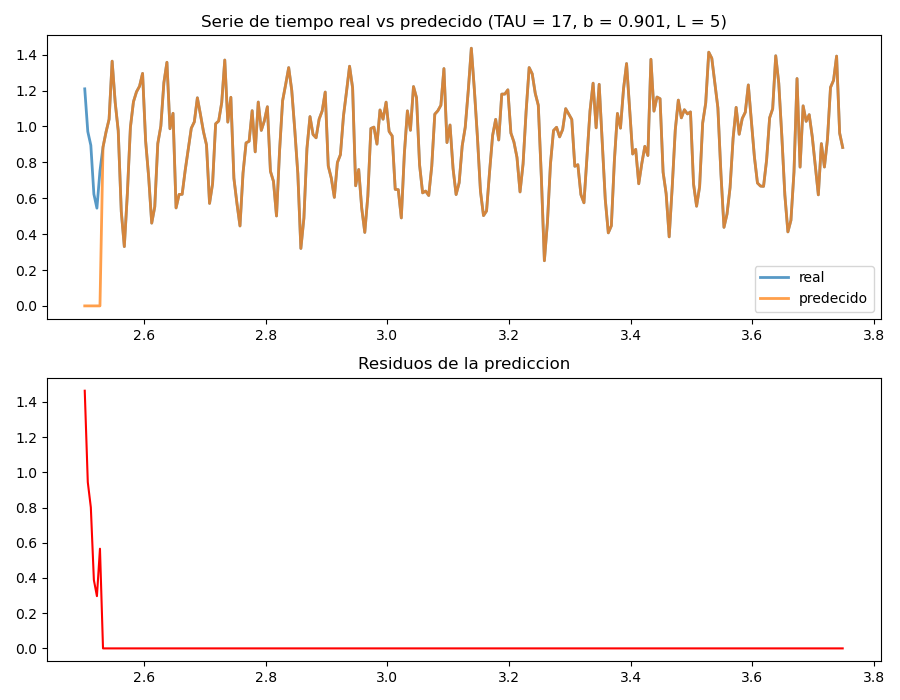

Text(0.5, 1.0, 'Residuos de la prediccion')

In [17]:
L = best_L_t17
b = best_b_t17
y_pred17_rls = np.zeros(shape=(len(y_valid17)))
myfilter = Filtro_RLS(L, b)
#Entrenamiento 
for k in range(L+1, len(y_train17)):
    myfilter.update(y_train17[k-L-1:k][::-1], y_train17[k])
#validacion

for k in range(L+1, len(y_valid17)):
    y_pred17_rls[k] = myfilter.update(y_valid17[k-L-1:k][::-1], y_valid17[k])
    
fig, ax = plt.subplots(2, 1, figsize=(9, 7), tight_layout=True)
ax[0].plot(t_valid17, y_valid17, linewidth=2, alpha=0.75, label='real')
ax[0].set_title('Serie de tiempo real vs predecido (TAU = 17, b = '+str(b)+', L = '+str(L)+')')
ax[0].plot(t_valid17, y_pred17_rls, linewidth=2, alpha=0.75, label='predecido')
ax[0].legend()
ax[1].plot(t_valid17,(y_valid17-y_pred17_rls)**2, color = 'red', label= 'tau = 17')
ax[1].set_title('Residuos de la prediccion')

#### Observaciones

Al ocupar el filtro Rls podemos ver que los valores predecidos son practicamente iguales que los valores reales. tambien de que al ser iguales, no existe residuo en las prediciones.

### Respuesta 1.2.3 (TAU = 30)

In [19]:
L = [5,10,15,20,25,30]
b = np.arange(0.9,1,0.001)
best_b_t30 = 0
best_L_t30 = 0
best_NMSE_t30 = 0
(t_train30, y_train30), (t_valid30, y_valid30), (t_test30, y_test30) = MackeyGlass(tau=30.)
y_pred30 = np.zeros(shape=(len(y_valid30)))

for i in range(len(L)):
    for j in range(len(b)):   
        myfilter = Filtro_RLS(L[i], b[j])
        #Entrenamiento 
        for k in range(L[i]+1, len(y_train30)):
            myfilter.update(y_train30[k-L[i]-1:k][::-1], y_train30[k])
        #validacion
        for k in range(L[i]+1, len(y_valid30)):
            y_pred30[k] = myfilter.update(y_valid30[k-L[i]-1:k][::-1], y_valid30[k])
        if (i == 0 and j ==0):
            best_NMSE_t30 = NMSE(y_valid30,y_pred30)
            best_b_t30= b[j]
            best_L_t30 = L[i]
        else:
            error = NMSE(y_valid30,y_pred30)
            if(error < best_NMSE_t30):
                best_NMSE_t30 = error
                best_b_t30= b[j]
                best_L_t30 = L[i]
            else:
                print(str(error)+' no es menor que : '+str(best_NMSE_t30)+', L = '+str(L[i])+' b = '+str(b[j]))
    print('-----------------------------------------------------------------------------------------------')
print('Mejor L: '+str(best_L_t30))
print('Mejor b: '+str(best_b_t30))

19.916949186557154 no es menor que : 19.916904989369538, L = 5 b = 0.901
19.916974480046605 no es menor que : 19.916904989369538, L = 5 b = 0.902
19.91732257653394 no es menor que : 19.916904989369538, L = 5 b = 0.903
19.927502807643794 no es menor que : 19.916904989369538, L = 5 b = 0.904
19.926627350733725 no es menor que : 19.91686021830534, L = 5 b = 0.906
19.9266240864279 no es menor que : 19.91686021830534, L = 5 b = 0.907
20.31856969682339 no es menor que : 19.91686021830534, L = 5 b = 0.908
20.099121530276076 no es menor que : 19.91686021830534, L = 5 b = 0.909
20.053994047815266 no es menor que : 19.91686021830534, L = 5 b = 0.91
28.93931391804735 no es menor que : 19.91686021830534, L = 5 b = 0.911
26114.145933165677 no es menor que : 19.91686021830534, L = 5 b = 0.912
234.12614294836408 no es menor que : 19.91686021830534, L = 5 b = 0.913
58.377117589713514 no es menor que : 19.91686021830534, L = 5 b = 0.914
188.6449596762318 no es menor que : 19.91686021830534, L = 5 b = 0

25.319390553984107 no es menor que : 19.91686021830534, L = 10 b = 0.905
25.28603538513162 no es menor que : 19.91686021830534, L = 10 b = 0.906
25.99310950903184 no es menor que : 19.91686021830534, L = 10 b = 0.907
25.553524932435568 no es menor que : 19.91686021830534, L = 10 b = 0.908
25.380936922538673 no es menor que : 19.91686021830534, L = 10 b = 0.909
26.508417428358133 no es menor que : 19.91686021830534, L = 10 b = 0.91
41.06577352446546 no es menor que : 19.91686021830534, L = 10 b = 0.911
78.2225722818535 no es menor que : 19.91686021830534, L = 10 b = 0.912
121.91678469245623 no es menor que : 19.91686021830534, L = 10 b = 0.913
26.170280647823517 no es menor que : 19.91686021830534, L = 10 b = 0.914
76.61318963623073 no es menor que : 19.91686021830534, L = 10 b = 0.915
138.9231234706403 no es menor que : 19.91686021830534, L = 10 b = 0.916
108.79218363500594 no es menor que : 19.91686021830534, L = 10 b = 0.917
261.16688049756107 no es menor que : 19.91686021830534, L =

30.77040123144091 no es menor que : 19.91686021830534, L = 15 b = 0.911
36.267576049584434 no es menor que : 19.91686021830534, L = 15 b = 0.912
54.722632452550144 no es menor que : 19.91686021830534, L = 15 b = 0.913
54.568763390160925 no es menor que : 19.91686021830534, L = 15 b = 0.914
8139.79772403797 no es menor que : 19.91686021830534, L = 15 b = 0.915
286.80872729505177 no es menor que : 19.91686021830534, L = 15 b = 0.916
1741.7787792127035 no es menor que : 19.91686021830534, L = 15 b = 0.917
3190.55020269698 no es menor que : 19.91686021830534, L = 15 b = 0.918
97.1669884834272 no es menor que : 19.91686021830534, L = 15 b = 0.919
61.50408667106076 no es menor que : 19.91686021830534, L = 15 b = 0.92
48.603253130620516 no es menor que : 19.91686021830534, L = 15 b = 0.921
63.110160469087326 no es menor que : 19.91686021830534, L = 15 b = 0.922
301.56897132276544 no es menor que : 19.91686021830534, L = 15 b = 0.923
460.2232405380152 no es menor que : 19.91686021830534, L = 1

1479.2536088420088 no es menor que : 19.91686021830534, L = 20 b = 0.914
9928.649960158578 no es menor que : 19.91686021830534, L = 20 b = 0.915
45.43746151305614 no es menor que : 19.91686021830534, L = 20 b = 0.916
1019.9418652652716 no es menor que : 19.91686021830534, L = 20 b = 0.917
865.6756669450872 no es menor que : 19.91686021830534, L = 20 b = 0.918
52.98610017626024 no es menor que : 19.91686021830534, L = 20 b = 0.919
238.8406227120839 no es menor que : 19.91686021830534, L = 20 b = 0.92
385.3794537848889 no es menor que : 19.91686021830534, L = 20 b = 0.921
58.36963483784632 no es menor que : 19.91686021830534, L = 20 b = 0.922
1952.5620378816973 no es menor que : 19.91686021830534, L = 20 b = 0.923
112.7599470448917 no es menor que : 19.91686021830534, L = 20 b = 0.924
28798.4737483059 no es menor que : 19.91686021830534, L = 20 b = 0.925
409.9279500573246 no es menor que : 19.91686021830534, L = 20 b = 0.926
3610.4695209281267 no es menor que : 19.91686021830534, L = 20 

44.183395086379825 no es menor que : 19.91686021830534, L = 25 b = 0.915
45.13156191489825 no es menor que : 19.91686021830534, L = 25 b = 0.916
136.52504397930105 no es menor que : 19.91686021830534, L = 25 b = 0.917
66.47410345125161 no es menor que : 19.91686021830534, L = 25 b = 0.918
13365.35899816491 no es menor que : 19.91686021830534, L = 25 b = 0.919
49.53607818849862 no es menor que : 19.91686021830534, L = 25 b = 0.92
190.76244898548504 no es menor que : 19.91686021830534, L = 25 b = 0.921
253.08563093343562 no es menor que : 19.91686021830534, L = 25 b = 0.922
76.01616397413014 no es menor que : 19.91686021830534, L = 25 b = 0.923
58.0799679511684 no es menor que : 19.91686021830534, L = 25 b = 0.924
108.71281498807262 no es menor que : 19.91686021830534, L = 25 b = 0.925
346.39311977400234 no es menor que : 19.91686021830534, L = 25 b = 0.926
45.56293123144918 no es menor que : 19.91686021830534, L = 25 b = 0.927
205.0524937777217 no es menor que : 19.91686021830534, L = 2

56.6579568717349 no es menor que : 19.91686021830534, L = 30 b = 0.923
47.06636208542947 no es menor que : 19.91686021830534, L = 30 b = 0.924
101.03692284558511 no es menor que : 19.91686021830534, L = 30 b = 0.925
124.8303951413789 no es menor que : 19.91686021830534, L = 30 b = 0.926
46.01213087198252 no es menor que : 19.91686021830534, L = 30 b = 0.927
60.70248835327472 no es menor que : 19.91686021830534, L = 30 b = 0.928
86.45784883167134 no es menor que : 19.91686021830534, L = 30 b = 0.929
920.466164305071 no es menor que : 19.91686021830534, L = 30 b = 0.93
1750.5216896072986 no es menor que : 19.91686021830534, L = 30 b = 0.931
65.0403740489479 no es menor que : 19.91686021830534, L = 30 b = 0.932
82.55242526810524 no es menor que : 19.91686021830534, L = 30 b = 0.933
232.49522073797485 no es menor que : 19.91686021830534, L = 30 b = 0.934
126.18912258485418 no es menor que : 19.91686021830534, L = 30 b = 0.935
440.27895893963785 no es menor que : 19.91686021830534, L = 30 b

<IPython.core.display.Javascript object>


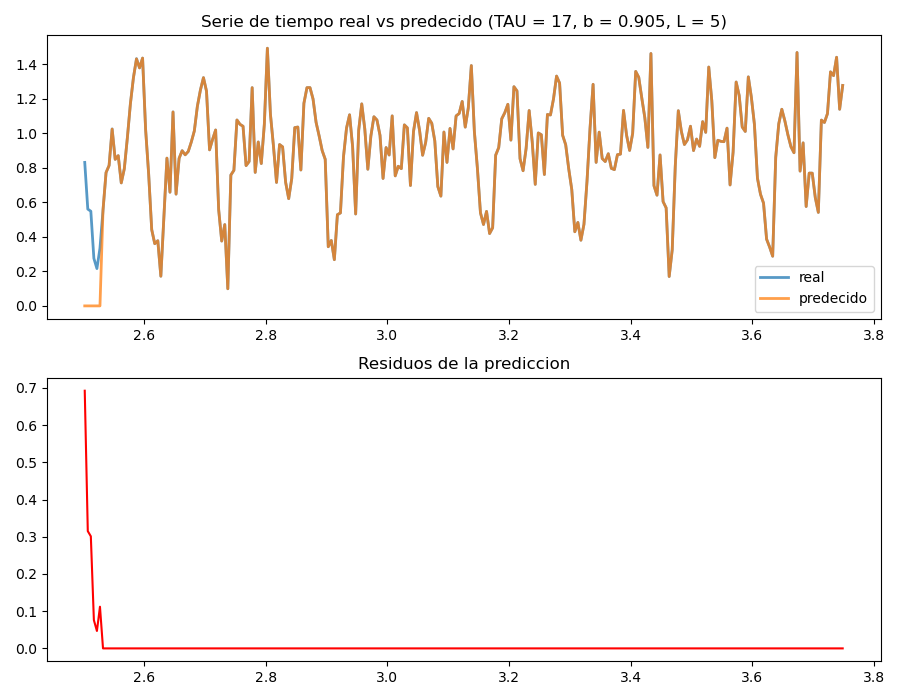

Text(0.5, 1.0, 'Residuos de la prediccion')

In [20]:
L = best_L_t30
b = best_b_t30
y_pred30_rls = np.zeros(shape=(len(y_valid30)))
myfilter = Filtro_RLS(L, b)
#Entrenamiento 
for k in range(L+1, len(y_train30)):
    myfilter.update(y_train30[k-L-1:k][::-1], y_train30[k])
#validacion

for k in range(L+1, len(y_valid30)):
    y_pred30_rls[k] = myfilter.update(y_valid30[k-L-1:k][::-1], y_valid30[k])
    
fig, ax = plt.subplots(2, 1, figsize=(9, 7), tight_layout=True)
ax[0].plot(t_valid30, y_valid30, linewidth=2, alpha=0.75, label='real')
ax[0].set_title('Serie de tiempo real vs predecido (TAU = 17, b = '+str(b)+', L = '+str(L)+')')
ax[0].plot(t_valid30, y_pred30_rls, linewidth=2, alpha=0.75, label='predecido')
ax[0].legend()
ax[1].plot(t_valid17,(y_valid30-y_pred30_rls)**2, color = 'red', label= 'tau = 30')
ax[1].set_title('Residuos de la prediccion')

#### Observaciones

Al igual que para el sistema debilmente caotico, en el sistema fuertemente caotico los valores son practicamente iguales. dicho esto podemos decir que no hay diferencia al ocupar este filtro en ambos sistemas

### Respuesta 1.2.4 

#### Comparacion resultados anteriores

A comparacion al filtro LMS que existia una diferencia clara en el ajuste de los resultado al utilizar un sistema debil o fuertemente caotico, podemos ver que el filtro RLS no tiene esta caracteriztica. haciendo que ambos sistemas convergan al mismo tiempo.

#### Prediccion conjunto de pruebas

<IPython.core.display.Javascript object>


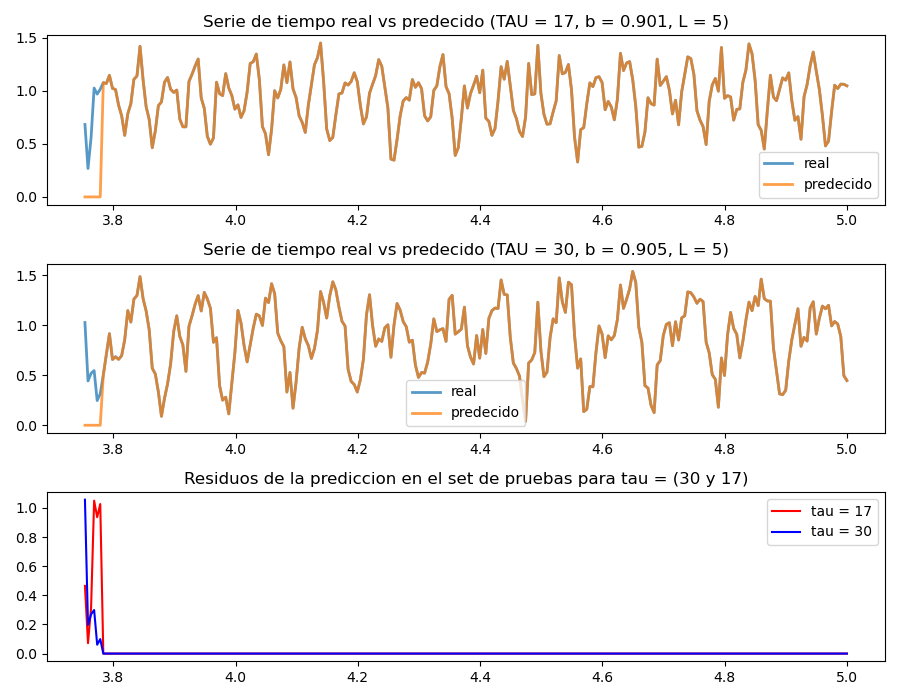

In [23]:
L17 = best_L_t17
b17 = best_b_t17
L30 = best_L_t30
b30 = best_b_t30

#tau 17
y_pred17_rls = np.zeros(shape=(len(y_test17)))
myfilter = Filtro_RLS(L17, b17)
#Entrenamiento 
for k in range(L17+1, len(y_train17)):
    myfilter.update(y_train17[k-L17-1:k][::-1], y_train17[k])
#test
for k in range(L17+1, len(y_test17)):
    y_pred17_rls[k] = myfilter.update(y_test17[k-L17-1:k][::-1], y_test17[k])
    
fig, ax = plt.subplots(3, 1, figsize=(9, 7), tight_layout=True)
ax[0].plot(t_test17, y_test17, linewidth=2, alpha=0.75, label='real')
ax[0].set_title('Serie de tiempo real vs predecido (TAU = 17, b = '+str(b17)+', L = '+str(L17)+')')
ax[0].plot(t_test17, y_pred17_rls, linewidth=2, alpha=0.75, label='predecido')
ax[0].legend()

#tau 30
y_pred30_rls = np.zeros(shape=(len(y_test30)))
myfilter = Filtro_RLS(L30, b30)
#Entrenamiento 
for k in range(L30+1, len(y_train30)):
    myfilter.update(y_train30[k-L30-1:k][::-1], y_train30[k])
#test
for k in range(L30+1, len(y_test30)):
    y_pred30_rls[k] = myfilter.update(y_test30[k-L30-1:k][::-1], y_test30[k])
    
ax[1].plot(t_test30, y_test30, linewidth=2, alpha=0.75, label='real')
ax[1].set_title('Serie de tiempo real vs predecido (TAU = 30, b = '+str(b30)+', L = '+str(L30)+')')
ax[1].plot(t_test30, y_pred30_rls, linewidth=2, alpha=0.75, label='predecido')
ax[1].legend()


#Residuos
ax[2].plot(t_test17,(y_test17-y_pred17_rls)**2, color = 'red', label= 'tau = 17')
ax[2].plot(t_test30,(y_test30-y_pred30_rls)**2, color = 'blue', label= 'tau = 30')
ax[2].set_title('Residuos de la prediccion en el set de pruebas para tau = (30 y 17)')
ax[2].legend()

#### Discucion y analisis

Para el set de prueba es practicamente lo mismo, las soluciones predecidas son exactas.

## Comparacion LMS y RLS

<IPython.core.display.Javascript object>


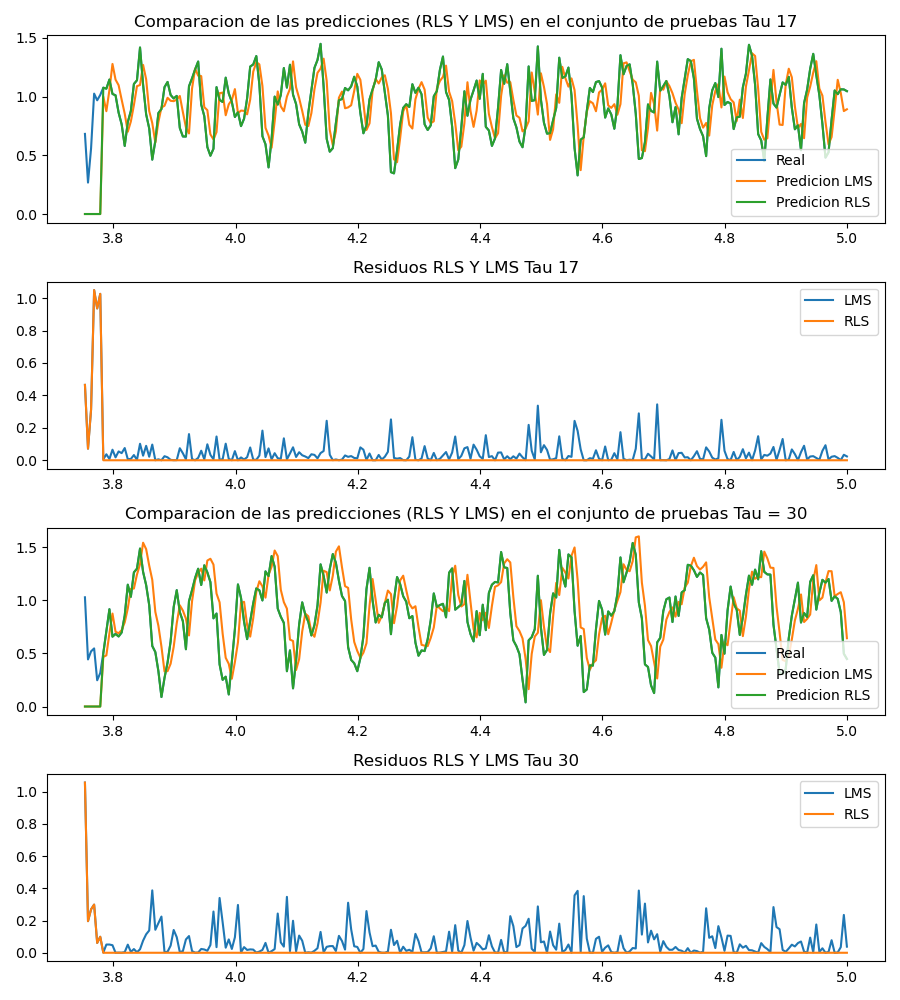

Text(0.5, 1.0, 'Residuos RLS Y LMS Tau 30')

In [262]:
fig, ax = plt.subplots(4, 1, figsize=(9, 10), tight_layout=True)
ax[0].plot(t_test17,y_test17, label = 'Real')
ax[0].plot(t_test17,y_pred17_lms, label = 'Predicion LMS')
ax[0].plot(t_test17,y_pred17_rls, label = 'Predicion RLS')
ax[0].legend()
ax[0].set_title('Comparacion de las predicciones (RLS Y LMS) en el conjunto de pruebas Tau 17')

ax[1].plot(t_test17,(y_test17-y_pred17_lms)**2, label = 'LMS')
ax[1].plot(t_test17,(y_test17-y_pred17_rls)**2, label = 'RLS')
ax[1].legend()
ax[1].set_title('Residuos RLS Y LMS Tau 17')

ax[2].plot(t_test30,y_test30, label = 'Real')
ax[2].plot(t_test30,y_pred30_lms, label = 'Predicion LMS')
ax[2].plot(t_test30,y_pred30_rls, label = 'Predicion RLS')
ax[2].legend()
ax[2].set_title('Comparacion de las predicciones (RLS Y LMS) en el conjunto de pruebas Tau = 30')

ax[3].plot(t_test30,(y_test30-y_pred30_lms)**2, label = 'LMS')
ax[3].plot(t_test30,(y_test30-y_pred30_rls)**2, label = 'RLS')
ax[3].legend()
ax[3].set_title('Residuos RLS Y LMS Tau 30')


#### Analisis

Es recomendable el uso de un filtro RLS ya que este logra captar con eficacia los datos predecidos a comparacion con el filtro LMS que este tiene un error mayor. ademas tambien podemos ver que la convergencia del filtro RLS es muy superior. 